In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import RidgeClassifier
from sklearn.utils.extmath import softmax

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'claim'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

In [4]:
class RidgeClassifierwithProba(RidgeClassifier):
    def predict_proba(self, X):
        d = self.decision_function(X)
        d_2d = np.c_[-d, d]
        return softmax(d_2d)

# Datasets

In [5]:
INPUT = Path("../input/tabular-playground-series-sep-2021")

train = pd.DataFrame(pd.read_csv(INPUT / "train.csv")[target])
#test = pd.read_csv(INPUT / "test.csv")
test = pd.DataFrame()
submission = pd.read_csv(INPUT / "sample_solution.csv")

In [6]:
train['lgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb_oof.npy")
test['lgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb_pred.npy")

train['lgb2_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb2_oof.npy")
test['lgb2_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb2_pred.npy")

train['xgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_xgb_oof.npy")
test['xgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_xgb_pred.npy")

train['lgb_bizen_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_bizen_oof.npy")
test['lgb_bizen_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_bizen_pred.npy")

train['lgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_dmitry_oof.npy")
test['lgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_dmitry_pred.npy")

train['xgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_dmitry_oof.npy")
test['xgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_dmitry_pred.npy")

train['lgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_manav_oof.npy")
test['lgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_manav_pred.npy")

train['xgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_manav_oof.npy")
test['xgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_manav_pred.npy")


In [7]:
train['ridge_pred'] = np.load("../input/tps-sep-lv0-base-trees/ridge_oof.npy")
test['ridge_pred'] = np.load("../input/tps-sep-lv0-base-trees/ridge_pred.npy")

train['nn_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_nn_oof.npy")
test['nn_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_nn_pred.npy")

In [8]:
#lv1 pred

train['lgb_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/lgb_lv1_oof.npy")
test['lgb_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/lgb_lv1_pred.npy")

train['xgb_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/xgb_lv1_oof.npy")
test['xgb_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/xgb_lv1_pred.npy")

train['ctb_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/ctb_lv1_oof.npy")
test['ctb_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/ctb_lv1_pred.npy")

train['ridge_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/ridge_lv1_oof.npy")
test['ridge_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/ridge_lv1_pred.npy")

train['nn_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/agg_nn_lv1_oof.npy")
test['nn_lv1n_pred'] = np.load("../input/tps-sep-lv1-nn/agg_nn_lv1_pred.npy")

In [9]:
#own

#train['ridge_lv2n_pred'] = np.load("../input/tps-sep-lv2/ridge_lv2n_oof.npy")
#test['ridge_lv2n_pred'] = np.load("../input/tps-sep-lv2/ridge_lv2n_pred.npy")

#train['ridge_lv2nre_pred'] = np.load("../input/tps-sep-lv2/ridge_lv2nre_oof.npy")
#test['ridge_lv2nre_pred'] = np.load("../input/tps-sep-lv2/ridge_lv2nre_pred.npy")

train['ridge_lv2nre2_pred'] = np.load("../input/tps-sep-lv2/ridge_lv2nre2_oof.npy")
test['ridge_lv2nre2_pred'] = np.load("../input/tps-sep-lv2/ridge_lv2nre2_pred.npy")

# Preprocessing

In [10]:
features = [col for col in train.columns if 'pred' in col]

In [11]:
ss = StandardScaler()

In [12]:
test[features]

,lgb_pred,lgb2_pred,xgb_pred,lgb_bizen_pred,lgb_dmitry_pred,xgb_dmitry_pred,lgb_manav_pred,xgb_manav_pred,ridge_pred,nn_pred,lgb_lv1n_pred,xgb_lv1n_pred,ctb_lv1n_pred,ridge_lv1n_pred,nn_lv1n_pred,ridge_lv2nre2_pred
0,0.558734,0.578699,0.576973,0.561836,0.566536,0.575204,0.564575,0.564908,0.553440,0.564283,0.568860,0.568343,0.567958,0.552885,0.916505,0.533451
1,0.130124,0.120648,0.124073,0.119917,0.126946,0.126340,0.121656,0.120459,0.182040,0.120549,0.124741,0.120441,0.121767,0.181629,0.871857,0.101673
2,0.634854,0.628457,0.630655,0.629326,0.627686,0.635330,0.626681,0.633499,0.631720,0.569874,0.625771,0.622298,0.617185,0.624617,0.921466,0.596096
3,0.121661,0.125785,0.126651,0.128635,0.122506,0.123506,0.128684,0.131022,0.184237,0.120917,0.129819,0.126351,0.125507,0.184000,0.871854,0.102130
4,0.151700,0.150161,0.149483,0.153291,0.146343,0.143437,0.152862,0.153132,0.203202,0.124316,0.157071,0.154612,0.152657,0.202919,0.874676,0.106224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493469,0.833647,0.829336,0.829659,0.827457,0.825696,0.827184,0.831222,0.816129,0.790480,0.587796,0.822190,0.842848,0.829848,0.775431,0.941457,0.732991
493470,0.114116,0.116351,0.117947,0.111374,0.112238,0.115928,0.111981,0.109487,0.174385,0.120834,0.113415,0.108547,0.112734,0.173952,0.870831,0.100347
493471,0.771955,0.760704,0.758474,0.758873,0.764026,0.754300,0.756039,0.774203,0.751130,0.580247,0.768531,0.759421,0.780321,0.737343,0.934492,0.690855
493472,0.129603,0.132275,0.129645,0.133944,0.135123,0.132036,0.135098,0.136081,0.184900,0.122772,0.131957,0.130094,0.131022,0.184348,0.872343,0.102268


In [13]:
train[target]

0         1
1         0
2         1
3         1
4         1
         ..
957914    0
957915    1
957916    0
957917    1
957918    0
Name: claim, Length: 957919, dtype: int64

# Ridge

In [14]:
ridge_params = {
                'max_iter':N_ESTIMATORS,
               'tol':1e-8,
    
                'alpha': 0.06690070586174424, 
                'solver': 'cholesky'
}

In [15]:
ridge_oof = np.zeros(train.shape[0])
ridge_pred = np.zeros(test.shape[0])
ridge_importances = pd.DataFrame()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=range(SEED, SEED+20)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")


    X_train = train[features].iloc[trn_idx]
    y_train = train[target].iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = train[target].iloc[val_idx]
    X_test = test[features]

        
    X_train[features] = ss.fit_transform(X_train[features])
    X_valid[features] = ss.transform(X_valid[features])
    X_test[features] = ss.transform(X_test[features])

    start = time.time()
    for inseed in seed_list:
        ridge_params['random_state'] = inseed

        model = RidgeClassifierwithProba(**ridge_params)
        model.fit(
            X_train, 
            y_train,
            
        )

        with open(f"ridge_model{fold}_seed{inseed}.pkl", 'wb') as f:
            pickle.dump(model, f)


        ridge_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
        ridge_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)


    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, ridge_oof[val_idx])
    print(f"fold {fold} - ridge auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

ridge_pred /= N_SPLITS
print(f"oof ridge_auc = {roc_auc_score(train[target], ridge_oof)}")

np.save("ridge_oof.npy", ridge_oof)
np.save("ridge_pred.npy", ridge_pred)

===== fold 0 =====
fold 0 - ridge auc: 0.817411, elapsed time: 14.34sec

===== fold 1 =====
fold 1 - ridge auc: 0.816385, elapsed time: 13.66sec

===== fold 2 =====
fold 2 - ridge auc: 0.817969, elapsed time: 14.34sec

===== fold 3 =====
fold 3 - ridge auc: 0.816598, elapsed time: 13.70sec

===== fold 4 =====
fold 4 - ridge auc: 0.818187, elapsed time: 14.13sec

===== fold 5 =====
fold 5 - ridge auc: 0.815620, elapsed time: 13.74sec

===== fold 6 =====
fold 6 - ridge auc: 0.819614, elapsed time: 14.20sec

===== fold 7 =====
fold 7 - ridge auc: 0.815726, elapsed time: 13.79sec

===== fold 8 =====
fold 8 - ridge auc: 0.817425, elapsed time: 14.27sec

===== fold 9 =====
fold 9 - ridge auc: 0.816499, elapsed time: 13.86sec

oof ridge_auc = 0.8171436931181472


# OOF predictions

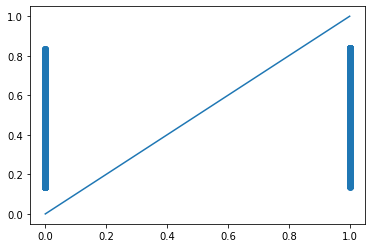

In [16]:
plt.plot(train[target], train[target])
plt.scatter(train[target], ridge_oof)

# Submission

In [17]:
submission[target] = ridge_pred
submission.to_csv("submission.csv", index=False)

submission

,id,claim
0,957919,0.529255
1,957920,0.129242
2,957921,0.589933
3,957922,0.129878
4,957923,0.134740
...,...,...
493469,1451388,0.734558
493470,1451389,0.127152
493471,1451390,0.687329
493472,1451391,0.130011


# Log

/////// 8 trees + ridge /////////
ver1

/////// 8 trees + ridge + nn /////////
ver2


/// re-input lv2 ridge nn ///
ver3

/// re-input2 lv2 ridge nn ///
ver4